In [1]:
import matplotlib.pyplot as plt
from numpy.random import default_rng
import numpy as np
import torch

from utils import split_data, train,  energy_lj, get_forces, MLP
import torch.nn.functional as F
from torch import nn
from torch.utils.data import  DataLoader
from IPython.display import clear_output
import numpy as np

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# check if a GPU is available
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

'cpu'

## MD step function

In [4]:
rng = default_rng(23)


def langevin_step(
    r: torch.tensor,
    v: torch.tensor,
    f: torch.tensor,
    energy_fn: callable,
    dt: float,
    lc: float
):
    """Langevin step: MD in NVT ensemble.

    Parameters
    ----------
    r: positions

    v: velocities

    f: forces

    dt: time step

    lc: Parameters Langevin dynamics

    energy_fn: energy function

    Return
    ------
    r: updated position

    v: updated velocities

    f: updated forces


    """
    com = torch.mean(v, axis=0)
    v -= com

    # langevin thermo, 1st half step
    v = lc[0] * v + lc[1] * torch.normal(mean=0., std=1., size=(v.shape))

    # Verlet part of MD step
    v = v + 0.5 * f * dt

    # update positions
    r = r + v * dt

    f = get_forces(energy_fn, r)

    v = v + 0.5 * f * dt

    # langevin thermo, 2nd half step
    v = lc[0] * v + lc[1] * torch.normal(mean=0., std=1.,size=(v.shape))

    return r, v, f

## Run MD

In [6]:
d = 1.1

# 3d cluster
clus3d = torch.tensor(
    [
        [0.0, 0.0, 0.0],
        [d / np.sqrt(2.), d / np.sqrt(2), 0.0],
        [-d / np.sqrt(2), d / np.sqrt(2), 0.0],
        [d / np.sqrt(2), -d / np.sqrt(2), 0.0],
        [-d / np.sqrt(2), -d / np.sqrt(2), 0.0],
        [0, 0, d],
        [0, 0, -d],
    ],dtype=torch.float32
)

# Refence energy: tensor(-9.1530)

In [5]:
def assign_MBv(n_particles, beta, m: float = 1.0):
    """Assign Maxwell-Boltzmann distributed velocities.

    Parameters
    ----------
    v: velocity array

    beta: 1/ (kB * T)

    m: atomic mass


    Return
    ------
    v:     velocity array

    """

    v = torch.normal(mean=0, std=np.sqrt(1.0 / (beta * m)), size=(n_particles, 3))

    return v

In [8]:
# compute LJ energy
energy = energy_lj(clus3d)

# set Boltzmann constant
beta = 40.
m = 1.0

dt =1e-3



In [9]:
r = torch.clone(clus3d)
n_particles = len(r)
n_dimensions = r.shape[-1]

In [10]:

# assign intial MB velocities
v = assign_MBv(n_particles, beta, m)

# compute initial forces
f = get_forces(energy_lj, r)


In [10]:
# initialize number of MD steps
n_steps = 10000

n_log = 50

# energies
potential_energies = torch.empty((n_steps // n_log,1))
positions = torch.empty((n_steps // n_log, n_particles, n_dimensions))

In [11]:
# initialize langevin parameters
lgamma = torch.tensor(1.0)
c1 = torch.exp(-lgamma*dt/2.0)
c2 = torch.sqrt((1.0-(c1*c1))/beta)
lc = torch.tensor([c1,c2])

In [13]:
# run Langevin
for i in range(n_steps):
    if i % n_log == 0:
        positions[i // n_log] = r
        potential_energies[i// n_log] = energy_lj(r)

    r, v, f = langevin_step(r, v, f,energy_lj, dt, lc)



## 1.1 MD simulation

* A low-temperature simulation with β = 40,
* A high-temperature simulation with β = 4,
* A high-temperature simulation (β = 4) with six particles. To obtain the initial structure,
remove the particle located at (0,0,0).

In [47]:
from tqdm import trange

beta = [40, 4, 4]
clus3d_6 = torch.tensor(
    [
        [d / np.sqrt(2.), d / np.sqrt(2), 0.0],
        [-d / np.sqrt(2), d / np.sqrt(2), 0.0],
        [d / np.sqrt(2), -d / np.sqrt(2), 0.0],
        [-d / np.sqrt(2), -d / np.sqrt(2), 0.0],
        [0, 0, d],
        [0, 0, -d],
    ],dtype=torch.float32
)
init_r = [torch.clone(clus3d), torch.clone(clus3d), torch.clone(clus3d_6)]

m = 1.0

# initialize number of MD steps
n_steps = 100000
n_log = 10
dt =1e-3

# energies & configs
E_pots = []
traj = []

for i in trange(3):
    r = init_r[i]
    n_particles = len(r)
    n_dimensions = r.shape[-1]

    # initialize langevin parameters
    lgamma = torch.tensor(1.0)
    c1 = torch.exp(-lgamma*dt/2.0)
    c2 = torch.sqrt((1.0-(c1*c1))/beta[i])
    lc = torch.tensor([c1,c2])

    potential_energies = torch.empty((n_steps // n_log,1))
    positions = torch.empty((n_steps // n_log, n_particles, n_dimensions))

    # assign intial MB velocities
    
    v = assign_MBv(n_particles, beta[i], m)

    # compute initial forces
    f = get_forces(energy_lj, r)

    # run Langevin
    for j in trange(n_steps):
        if j % n_log == 0:
            positions[j // n_log] = r
            potential_energies[j// n_log] = energy_lj(r)

        r, v, f = langevin_step(r, v, f, energy_lj, dt, lc)
    
    traj.append(positions)
    E_pots.append(potential_energies)

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:54<00:00, 18.03s/it]


In [48]:
torch.save(traj[1], "traj.pth") # PyTorch-specific format
torch.save(E_pots[1], "E_pots.pth")

Plot histograms of the potential energy distributions and show the radial distribution functions g(r) (already implemented in the notebook).

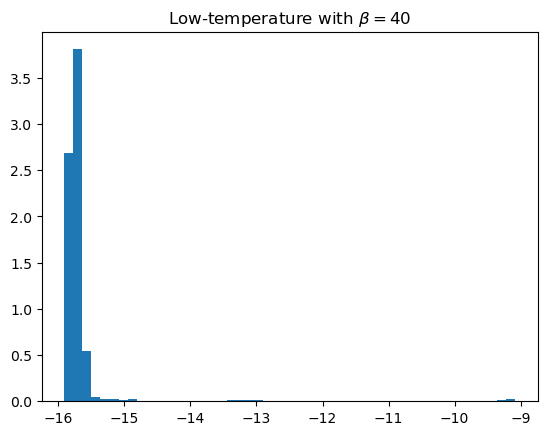

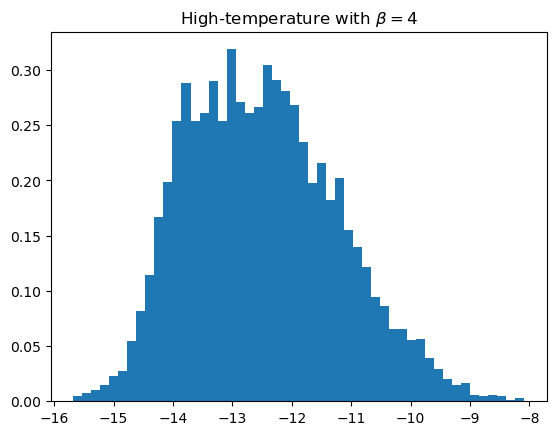

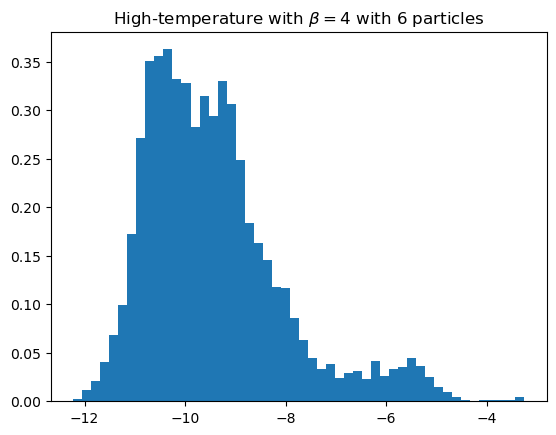

In [26]:
plt.figure()
plt.hist(E_pots[0].numpy(), bins=50, density=True)
plt.title(r"Low-temperature with $\beta=40$")
plt.show()


plt.figure()
plt.hist(E_pots[1].numpy(), bins=50, density=True)
plt.title(r"High-temperature with $\beta=4$")
plt.show()


plt.figure()
plt.hist(E_pots[2].numpy(), bins=50, density=True)
plt.title(r"High-temperature with $\beta=4$ with 6 particles")
plt.show()

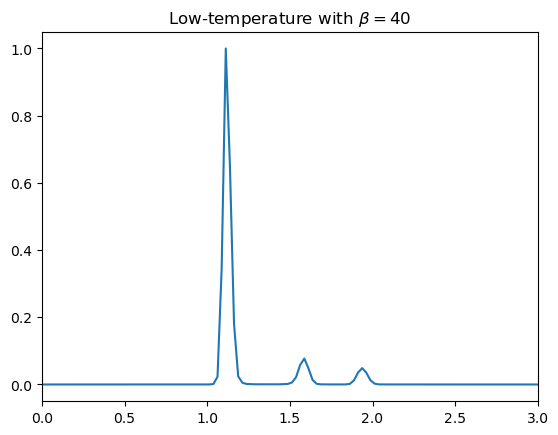

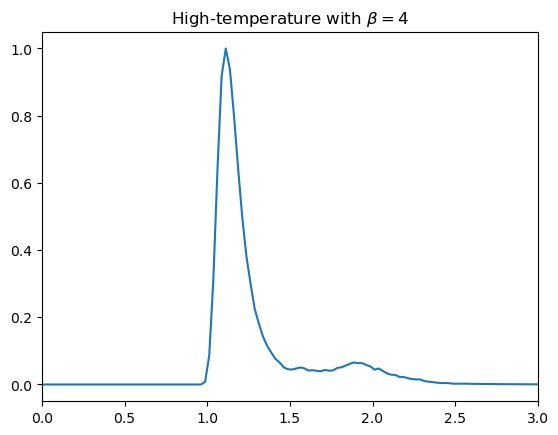

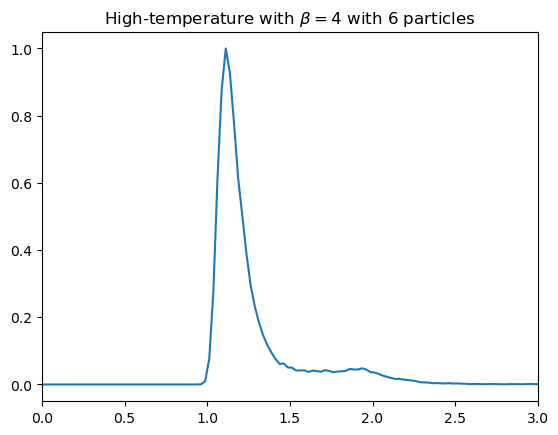

In [28]:
from utils import radial_distribution_function


rdf = radial_distribution_function(traj[0].detach().numpy())
plt.figure()
plt.plot(rdf[0], rdf[1] / rdf[1].max())
plt.xlim(0,3)
plt.title(r"Low-temperature with $\beta=40$")
plt.show()


rdf = radial_distribution_function(traj[1].detach().numpy())
plt.figure()
plt.plot(rdf[0], rdf[1] / rdf[1].max())
plt.xlim(0,3)
plt.title(r"High-temperature with $\beta=4$")
plt.show()


rdf = radial_distribution_function(traj[2].detach().numpy())
plt.figure()
plt.plot(rdf[0], rdf[1] / rdf[1].max())
plt.xlim(0,3)
plt.title(r"High-temperature with $\beta=4$ with 6 particles")
plt.show()

Q: How do the potential energy distributions and the radial distribution functions (RDF) differ for the case of low and high temperatures?

A: RDF is a measure of how particle density varies as a function of distance from a reference particle. At low temperature, most configurations have low potential energy as expected. There is not enough thermal energy for particles to move away from their initial positions which can be seen as sharp peaks in the RDF. At higher temperature, the potential energy has a skewed distribution (resembling the Maxwell-Boltzmann distribution? even though that's only applicable for the kinetic energy). There is now more thermal energy so more vibration and the RDF becomes continuous. Since the velocities are MB-distributed, the peak of the RDF is related to the most probable velocity. For small number of particles, the potential energy distribution has smaller variance as expected. There is not much difference in terms of RDF in comparison to the case with 7 particles.

## Behler-Parinello symmetry functions

In [6]:
def f_c(distance, r_cut):
    return torch.where(distance <= r_cut, 0.5 * (torch.cos(np.pi * distance / r_cut) + 1), 0)

"Bare" Behler-Parrinello functions, these functions do not involve a sum over neighboring atoms.

In [7]:
def g_1_func(distances, r_cut):
    return f_c(distances, r_cut)

def g_2_func(distances, eta, r_cut):
    return torch.exp(-eta*distances**2) * f_c(distances, r_cut)

def g_3_func(distances, kappa, r_cut):
    return torch.cos(kappa * distances) * f_c(distances, r_cut)

Behler-Parrinello symmetry defined as sum over all neighbors

In [8]:
# Distances refer to the distance array
# of the particle under consideration to all other particles
def g_1_feature(distances, r_cut):
    return torch.sum(g_1_func(distances, r_cut))

def g_2_feature(distances, eta, r_cut):
    return torch.sum(g_2_func(distances, eta, r_cut))

def g_3_feature(distances, kappa, r_cut):
    return torch.sum(g_3_func(distances, kappa, r_cut))

## 1.2 Dataset

In [9]:
from tqdm import tqdm

traj = torch.load("traj.pth")
d = 1.1

clus3d = torch.tensor(
    [
        [0.0, 0.0, 0.0],
        [d / np.sqrt(2.), d / np.sqrt(2), 0.0],
        [-d / np.sqrt(2), d / np.sqrt(2), 0.0],
        [d / np.sqrt(2), -d / np.sqrt(2), 0.0],
        [-d / np.sqrt(2), -d / np.sqrt(2), 0.0],
        [0, 0, d],
        [0, 0, -d],
    ],dtype=torch.float32
)
r_c = 4.0
eta = np.geomspace(0.01, 5.0, 10)
kappa = np.linspace(0.5, 5.0, 10)

n_samples = 2000
n_particles = len(clus3d)
n_features = 21 # 21 features per atom

features = torch.empty((n_samples, n_particles, n_features))
for i, config in tqdm(enumerate(traj[::5])): # 2000 samples
    for j in range(7):
        dist = torch.norm(torch.cat((config[:j], config[j+1:])) - config[j,:], dim=1)
        

        # 1 G_1 function
        features[i, j, 0] = g_1_feature(distances=dist, r_cut=r_c)

        # 10 G_2 functions
        for k in range(1, 11):
            features[i, j, k] = g_2_feature(distances=dist, eta=eta[k-1], r_cut=r_c) # R_s=0 is alr built into g_2_func
        
        # 10 G_3 functions
        for k in range(11, 21):
            features[i,j,k] = g_3_feature(distances=dist, kappa=kappa[k-11], r_cut=r_c)


0it [00:00, ?it/s]

2000it [00:07, 275.15it/s]


Create Datasets for testing and training and a training DataLoader using the potential energies
as labels (y-values).

In [10]:
from utils import split_data
from torch.utils.data import DataLoader

E_pot = torch.load("E_pots.pth")[::5]

## 1.3 Fitting the NN potential

Train an MLP on the generated data

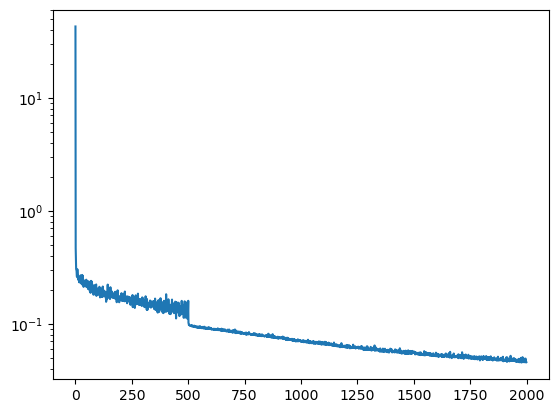

100%|██████████| 2000/2000 [07:35<00:00,  4.39it/s]


In [12]:
from utils import train, MLP
from itertools import product
from tqdm import trange
from torch import nn
from torchmetrics.functional import mean_squared_error
import matplotlib.pyplot as plt

no_of_hidden_layers = 3
no_of_nodes = 25
n_epochs = 2000
log_interval = 100

# Datasets
## Pairwise distances -> Energy
batch_size = 32

all_data, train_data, test_data = split_data(features.numpy(), E_pot.numpy(), train_fraction=.75, device= DEVICE)
trainloader = DataLoader(train_data, 
                         batch_size=batch_size, 
                         shuffle=True)
testloader = DataLoader(test_data, 
                         batch_size=batch_size, 
                         shuffle=True)



dimensions = [features.shape[2]] + [no_of_nodes]*no_of_hidden_layers + [1]

learning_rate = [1e-3, 1e-4]
criterion = nn.MSELoss()
model_feature = MLP(n_units=dimensions).to(DEVICE)

losses = []
for epoch in trange(n_epochs):
    if epoch > 500:
        lr = learning_rate[1]
    else:
        lr = learning_rate[0]
            
    optimizer = torch.optim.Adam(model_feature.parameters(), lr=lr)
    loss = train(model_feature, trainloader, optimizer, criterion, device=DEVICE)
    losses.append(loss)
    clear_output(wait=True)

    plt.plot(losses)
    plt.yscale('log')
    plt.show()

In [13]:
with torch.no_grad():
    E_pred = torch.sum(model_feature(torch.from_numpy(test_data.x)), dim=1)
print(f"First round:")
mse_test = mean_squared_error(torch.from_numpy(test_data.y), E_pred)
print(f"MSE  on test set: {mse_test}")

First round:
MSE  on test set: 0.05110056698322296


## 1.4 Running MD with the NN potential

In [16]:
r_c = 4.0
eta = np.geomspace(0.01, 5.0, 10)
kappa = np.linspace(0.5, 5.0, 10)

def energy_model(config: torch.tensor) -> float:
    # compute feature for configuration
    feature = torch.empty((1, len(config), 21))
    
    for j in range(7):
        dist = torch.norm(torch.cat((config[:j], config[j+1:])) - config[j,:], dim=1)

        # 1 G_1 function
        feature[0, j, 0] = g_1_feature(distances=dist, r_cut=r_c)

        # 10 G_2 functions
        for k in range(1, 11):
            feature[0, j, k] = g_2_feature(distances=dist, eta=eta[k-1], r_cut=r_c) # R_s=0 is alr built into g_2_func
        
        # 10 G_3 functions
        for k in range(11, 21):
            feature[0,j,k] = g_3_feature(distances=dist, kappa=kappa[k-11], r_cut=r_c)
    
    atomic_energies = torch.zeros((len(config), 1))
    for i in range(7): # 7 atoms
        atomic_energies[i,0]= model_feature(feature[0,i,:])

    
    return torch.sum(atomic_energies, axis=0)

print(f"Index of configuration with energy close to the mean energy: {np.abs(E_pot.numpy() - np.mean(E_pot.numpy())).argmin()}")

Index of configuration with energy close to the mean energy: 518


Use the energy_model function to run an MD simulation for 10 000 steps and store the energies every 2 steps. Use configurations from the previous MD trajectories with an energy close to the repective mean energy as starting point

In [21]:
beta = 4
# assign intial structure
pos = traj[518]
# assign intial MB velocities
v = assign_MBv(n_particles=len(pos), beta=beta)

# initialize number of MD steps
n_steps = 10000
n_log = 2
dt =1e-3

n_particles = len(pos)
n_dimensions = pos.shape[-1]

# initialize langevin parameters
lgamma = torch.tensor(1.0)
c1 = torch.exp(-lgamma*dt/2.0)
c2 = torch.sqrt((1.0-(c1*c1))/beta)
lc = torch.tensor([c1,c2])

potential_energies = torch.empty((n_steps // n_log,1))
positions = torch.empty((n_steps // n_log, n_particles, n_dimensions))


# compute initial forces
f = get_forces(energy_model, pos) # no analytic form for energy_model so yeah ofc use energy_lj

# run Langevin
for j in trange(n_steps):
    if j % n_log == 0:
        positions[j // n_log] = pos
        potential_energies[j// n_log] = energy_model(pos)

    pos, v, f = langevin_step(pos, v, f, energy_model, dt, lc)

100%|██████████| 10000/10000 [03:49<00:00, 43.49it/s]


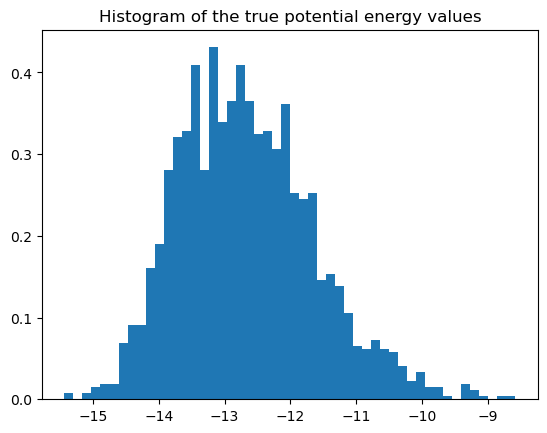

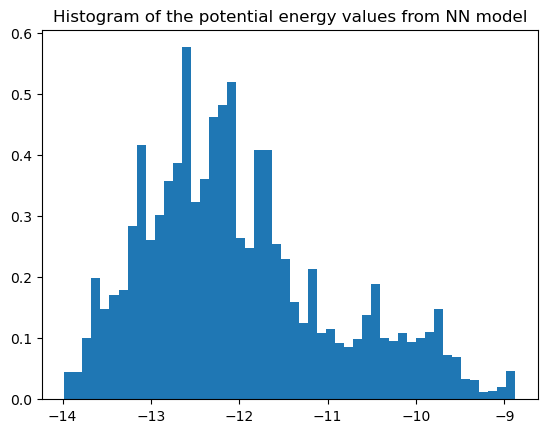

In [22]:
plt.figure()
plt.hist(E_pot.numpy(), bins=50, density=True)
plt.title("Histogram of the true potential energy values")
plt.show()

plt.figure()
plt.hist(potential_energies.detach().numpy(), bins=50, density=True)
plt.title("Histogram of the potential energy values from NN model")
plt.show()

# print(f"Energy fluctuation: {np.var(E_tot)=}")

Ha the potential energies from NN do not reflect the Maxwell-Boltzmann distribution at all...

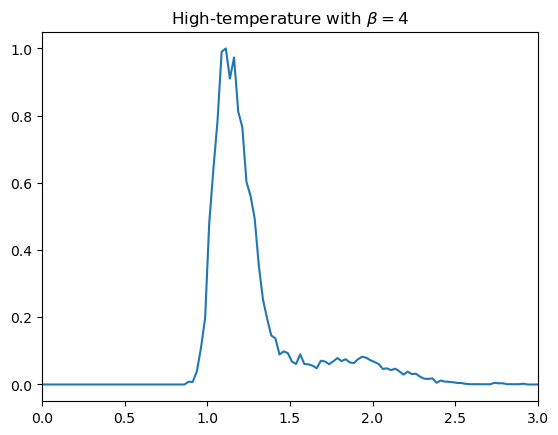

In [23]:
from utils import radial_distribution_function

rdf = radial_distribution_function(positions.detach().numpy())
plt.figure()
plt.plot(rdf[0], rdf[1] / rdf[1].max())
plt.xlim(0,3)
plt.title(r"High-temperature with $\beta=4$")
plt.show()

B-P NN is system size indepedent and good for learning local environment with r_c